In [349]:
%load_ext autoreload
%autoreload 2
import mubind as mb
import numpy as np
import pandas as pd
import torch
import torch.optim as topti
import torch.utils.data as tdata
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:0


In [350]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('../annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [451]:
# reverse operation (recover aminoacids from one-hot encoded representation
prot_seq = []
for r in x:
    keys_aa = mb.tl.get_protein_aa_index()
    # r = r.T
    # print(r.shape)
    # r = r.cpu().detach().numpy()
    seq = ''.join(np.array(sorted(keys_aa))[np.argmax(r, axis=0)]) # , axis=1)\
    # print(r.shape, seq)
    prot_seq.append(seq)

In [452]:
# shift signal by adding a constant s.t. no negative values are included
signal -= np.min(signal)

In [453]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

In [454]:
# df = df.head(1000)
df = df.reindex(df.var(axis=1).sort_values()[-100:].index)

In [469]:
df.shape

(100, 179)

In [455]:
dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = torch.nn.CrossEntropyLoss()

In [456]:
model = model.cuda()

In [457]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=50, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 50 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 3524.556029 , best epoch: 0 secs per epoch: 3.585 s
Epoch:  3, Loss: 16498.899591 , best epoch: 0 secs per epoch: 2.631 s
Epoch:  4, Loss: 43452.223472 , best epoch: 0 secs per epoch: 2.302 s
Epoch:  5, Loss: 82570.252560 , best epoch: 0 secs per epoch: 2.138 s
Epoch:  6, Loss: 111436.653317 , best epoch: 0 secs per epoch: 2.049 s
Epoch:  7, Loss: 166734.408224 , best epoch: 0 secs per epoch: 1.989 s
Epoch:  8, Loss: 227129.942656 , best epoch: 0 secs per epoch: 1.982 s
Epoch:  9, Loss: 314414.000743 , best epoch: 0 secs per epoch: 1.933 s
Epoch: 10, Loss: 377641.520755 , best epoch: 0 secs per epoch: 1.894 s
Epoch: 11, Loss: 619807.140067 , best epoch: 0 secs per epoch: 1.871 s
Epoch: 12, Loss: 730051.683346 , best epoch: 0 secs per epoch: 1.888 s
Epoch: 13, Loss: 1251458.973577 , best epoch: 0 secs per ep

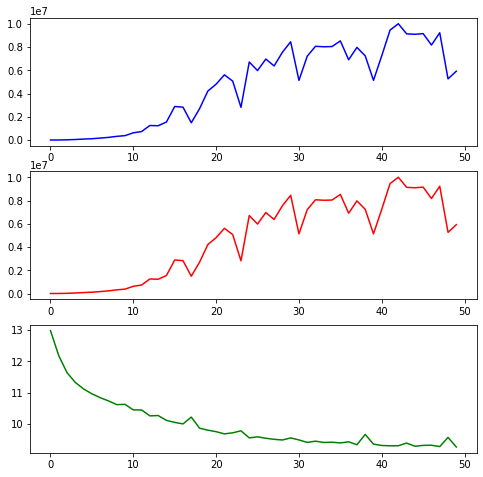

In [464]:
plt.subplot(3, 1, 1)
plt.plot(model.loss_history, 'b')
plt.subplot(3, 1, 2)
plt.plot(model.crit_history, 'r')
plt.subplot(3, 1, 3)
plt.plot(model.rec_history, 'g')

In [459]:
model.load_state_dict(model.best_model_state)

<All keys matched successfully>

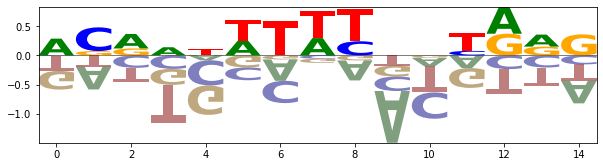

In [460]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x), device=device)[[0, 20, 50, 100, 150]])
bm_pred = bm_pred.cpu().detach().numpy()
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)
    break

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


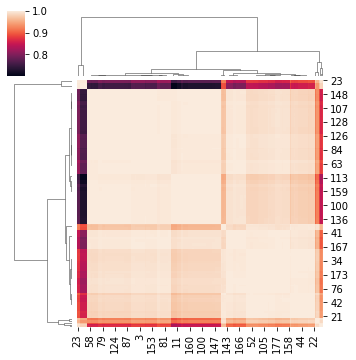

In [461]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x), device=device))
bm_pred = bm_pred.cpu().detach().numpy()
bm_df = bm_pred.reshape(-1, 60)
bm_df = pd.DataFrame(bm_df.T)
corr = bm_df.corr()
import seaborn as sns
sns.clustermap(corr, figsize=[5, 5])

### Explore the reconstructred aminoacid representations

In [471]:
outputs = []
rec = []
for i, batch in enumerate(train):
    # print(i) # batch)
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None

    store_rev = False
    if residues is not None and store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = (mononuc, mononuc_rev, b, countsum, residues)
    elif residues is not None:
        inputs = (mononuc, b, countsum, residues)
    elif store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = (mononuc, mononuc_rev, b, countsum)
    else:
        inputs = (mononuc, b, countsum)
        
    # print(inputs[0].shape[0])
    loss = None
    y, reconstruction = model(inputs)  # Forward pass through the network.
    # print(y.shape)
    outputs.append(list(np.array(y.cpu().detach().numpy())))
    rec.append(np.array(reconstruction.cpu().detach().numpy()))
    # break

In [438]:
len(outputs), len(rec)

(140, 140)

In [420]:
model(inputs)[1].shape

torch.Size([8, 88, 21])

In [407]:
len(outputs), len(rec)

(17800, 17800)

In [388]:
train.dataset.signal

(100, 178)

In [384]:
len(outputs)

17800

In [363]:
# reconstruction.shape
reconstruction = reconstruction.cpu().detach()

In [364]:
for r in reconstruction:
    print(r.shape)
    break

torch.Size([88, 21])


In [365]:
# reverse operation (recover aminoacids from one-hot encoded representation
# rec_seq = []
topi = {}
for i, r in enumerate(reconstruction):
    # print(i)
    if i % 10 == 0:
        print(i, len(reconstruction))
    keys_aa = mb.tl.get_protein_aa_index()
    r = r.T
    # print(r.shape)
    # r = r.cpu().detach().numpy()
    # seq = ''.join(np.array(sorted(keys_aa))[np.argmax(r, axis=0)]) # , axis=1)\
    # print(r.shape, seq)
    # rec_seq.append(seq)
    df = pd.DataFrame(r)
    
    # get the top i sequences per reconstruction
    n = 5
    for i in range(n):
        next_seq = ''
        if not i in topi:
            topi[i] = []
        next_seq = []
        for c in df:
            # print(c, df[c].nlargest(n).index)
            next_seq.append(df[c].nlargest(n).index[i])
        rec_seq = ''.join(np.array(sorted(keys_aa))[np.array(next_seq)])
        topi[i].append(rec_seq)
    

0 128
10 128
20 128
30 128
40 128
50 128
60 128
70 128
80 128
90 128
100 128
110 128
120 128


In [366]:
#reconstruction

In [367]:
real = pd.DataFrame([aa for aa in r] for r in prot_seq)
pred = pd.DataFrame([aa for aa in r] for r in topi[0])

In [368]:
equal = pd.DataFrame()
for c in pred:
    scores = [ai == bi for ai, bi in zip(pred[c], real[c])]
    # print(c, scores)
    equal[c] = np.array(scores, dtype=int)

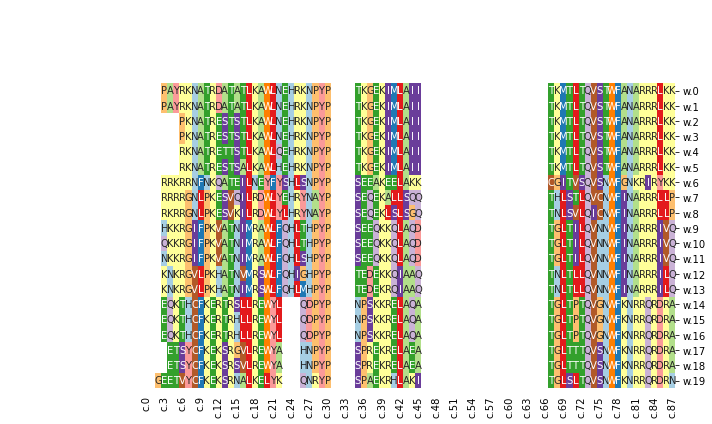

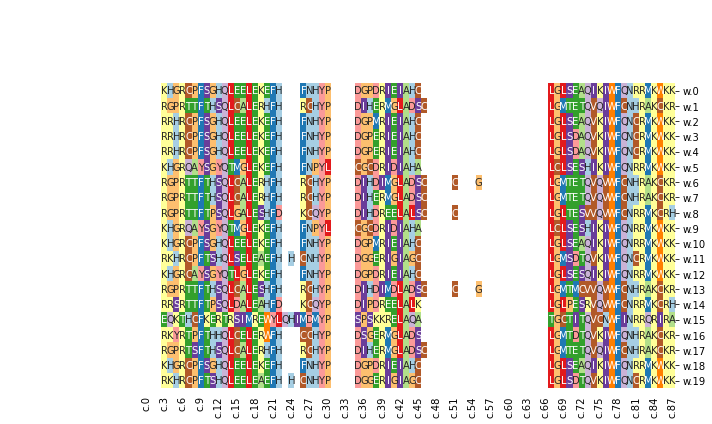

In [369]:
from matplotlib import rcParams
# rcParams['figure.figsize'] = 10, 2
mb.pl.alignment_protein(prot_seq[:20], figsize=[10, 6])
mb.pl.alignment_protein(topi[0][:20], figsize=[10, 6])

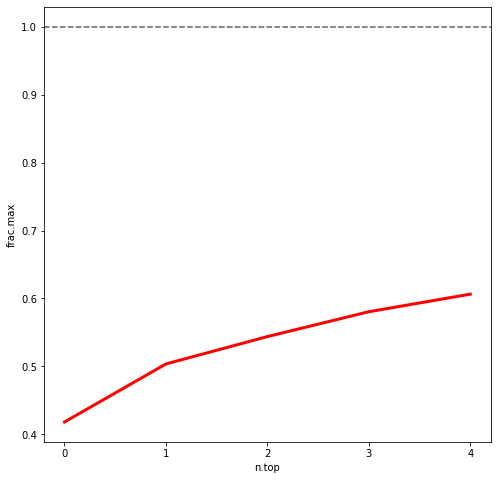

In [370]:
max_score = real.shape[0] * real.shape[1]

final_score = 0
res = []
for k in topi.keys():
    pred = pd.DataFrame([aa for aa in r] for r in topi[k])
    equal = pd.DataFrame()
    # print(pred.head())
    for c in pred:
        scores = [ai == bi for ai, bi in zip(pred[c], real[c])]
        # print(c, scores)
        equal[c] = np.array(scores, dtype=int)
        
    next_score = sum(equal.values.flatten())
    # print(k, next_score, max_score)
    final_score += next_score
    res.append([k, final_score, max_score])
    # print()
res = pd.DataFrame(res, columns=['n.top', 'final.score', 'max.score'])
res['frac.max'] = res['final.score'] / res['max.score']

rcParams['figure.figsize'] = 8, 8
sns.lineplot(data=res, x='n.top', y='frac.max', color='red', lw=3.0)
plt.xticks(list(topi.keys()));
plt.axhline(y=1.0, ls='--', c='gray')
plt.axhline(y=1.0, ls='--', c='gray')

In [372]:
# sns.heatmap(equal)